In [31]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import torch
import networkx as nx
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    GPT2Config
)

In [42]:
%pip install --upgrade networkx
%pip install umap-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
# Enable hidden states 
config = GPT2Config.from_pretrained("gpt2", output_hidden_states=True)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [92]:
input_text = """
When the number of classes is very large, it makes sense for the cumbersome model to be an ensemble that contains one generalist model trained on all the data and many “specialist” models, each
of which is trained on data that is highly enriched in examples from a very confusable subset of the
classes (like different types of mushroom). The softmax of this type of specialist can be made much
smaller by combining all of the classes it does not care about into a single dustbin class.


In contrast to the first and last layer interventions, the middle layers are remarkably robust to both deletion and minor order changes. When zooming in on the differences between the effect of swaps and drops for intermediate layers, we find that swapping adjacent layers is less harmful than ablating layers. These results match similar experiments performed on vision transformers [5]. We take this as evidence that certain operations within the forward pass are commutative, though further experimentation is required.
"""

In [93]:
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model(**inputs)

all_hidden_states = outputs.hidden_states

final_layer = all_hidden_states[-1]  # shape: [batch_size, seq_len, hidden_size]
mean_pooled = final_layer.mean(dim=1)  # shape: [batch_size, hidden_size]

token_emb_matrix = model.transformer.wte.weight.data  # shape: [vocab_size, hidden_dim]
print("Embedding matrix shape:", token_emb_matrix.shape)

Embedding matrix shape: torch.Size([50257, 768])


In [94]:

vocab_size = token_emb_matrix.shape[0]
num_samples = 15000  # vocab size 50257
indices = np.random.choice(vocab_size, size=num_samples, replace=False)
indices = sorted(indices)  # just to keep them in ascending order

#indices = np.arange(num_samples)  # [0..9999]
sampled_embs = token_emb_matrix[indices, :]  # shape [num_samples, hidden_dim]

token_id_to_pos = {}
for i, tid in enumerate(indices):
    token_id_to_pos[tid] = i

print("Sampled embedding shape:", sampled_embs.shape)

Sampled embedding shape: torch.Size([15000, 768])


In [95]:
# Convert these vocab indices into tokens
sampled_tokens = [tokenizer.convert_ids_to_tokens([idx])[0] for idx in indices]

In [96]:
import umap.umap_ as umap

# Example UMAP reducer
reducer = umap.UMAP(
    n_neighbors=5,      # how many neighbors each point has in local manifold
    n_components=2,      # 2D projection
    metric='euclidean',     # metric for distance calculation
    repulsion_strength=2
)

umap_result = reducer.fit_transform(sampled_embs)  # shape: [num_samples, 2]


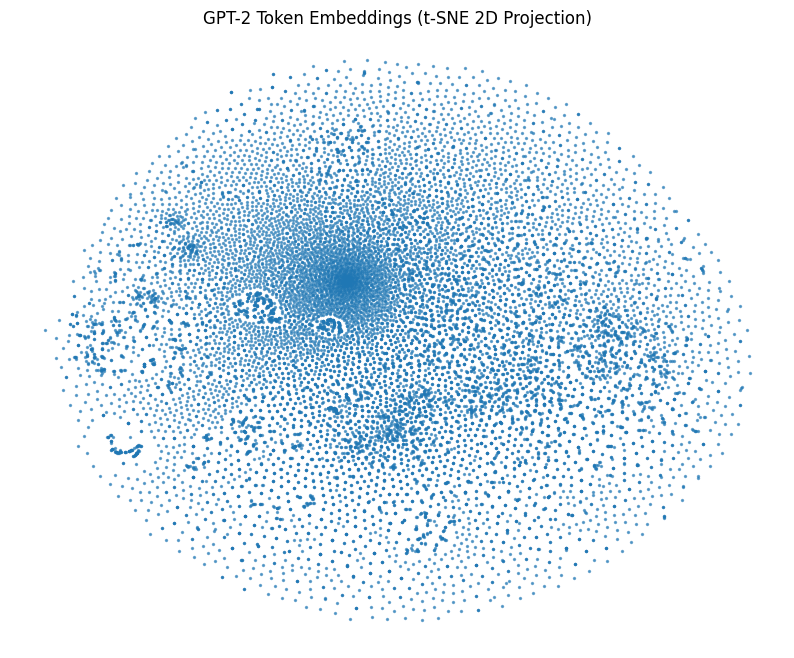

In [97]:
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=2, alpha=0.6)
plt.title("GPT-2 Token Embeddings (t-SNE 2D Projection)")
plt.axis("off")
plt.show()

In [104]:
# Making of graph

k = 5  
neighbors = NearestNeighbors(n_neighbors=k, metric="euclidean")
neighbors.fit(umap_result)
knn_graph = neighbors.kneighbors_graph(umap_result, mode="distance")


G = nx.Graph()
num_nodes = knn_graph.shape[0]
G.add_nodes_from(range(num_nodes))

# The .nonzero() method or .coo_matrix approach can enumerate edges
coo = knn_graph.tocoo()
for i, j, data in zip(coo.row, coo.col, coo.data):
    if i != j:
        G.add_edge(i, j, weight=data)

In [99]:
# coordinates as node attributes
for i in range(num_samples):
    G.nodes[i]["pos"] = (umap_result[i, 0], umap_result[i, 1])

token_id_to_pos = {}
for node_idx, token_id in enumerate(indices):
    token_id_to_pos[token_id] = node_idx



In [100]:
# GENERATIOn
input_ids = tokenizer.encode(input_text, return_tensors="pt")

max_new_tokens = 50
generated_token_ids = []  # store the final chosen tokens

for step in range(max_new_tokens):
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
    logits = outputs.logits[:, -1, :]  # shape [1, vocab_size], distribution over next token
    next_token_id = torch.argmax(logits, dim=-1)
    
    input_ids = torch.cat([input_ids, next_token_id.unsqueeze(-1)], dim=1)
    
    generated_token_ids.append(next_token_id.item())

final_text = tokenizer.decode(input_ids[0]) # input_ids[0] is tokenized input
print("Generated text:", final_text)
print("Generated token IDs:", generated_token_ids)


Generated text: 
When the number of classes is very large, it makes sense for the cumbersome model to be an ensemble that contains one generalist model trained on all the data and many “specialist” models, each
of which is trained on data that is highly enriched in examples from a very confusable subset of the
classes (like different types of mushroom). The softmax of this type of specialist can be made much
smaller by combining all of the classes it does not care about into a single dustbin class.


In contrast to the first and last layer interventions, the middle layers are remarkably robust to both deletion and minor order changes. When zooming in on the differences between the effect of swaps and drops for intermediate layers, we find that swapping adjacent layers is less harmful than ablating layers. These results match similar experiments performed on vision transformers [5]. We take this as evidence that certain operations within the forward pass are commutative, though further 

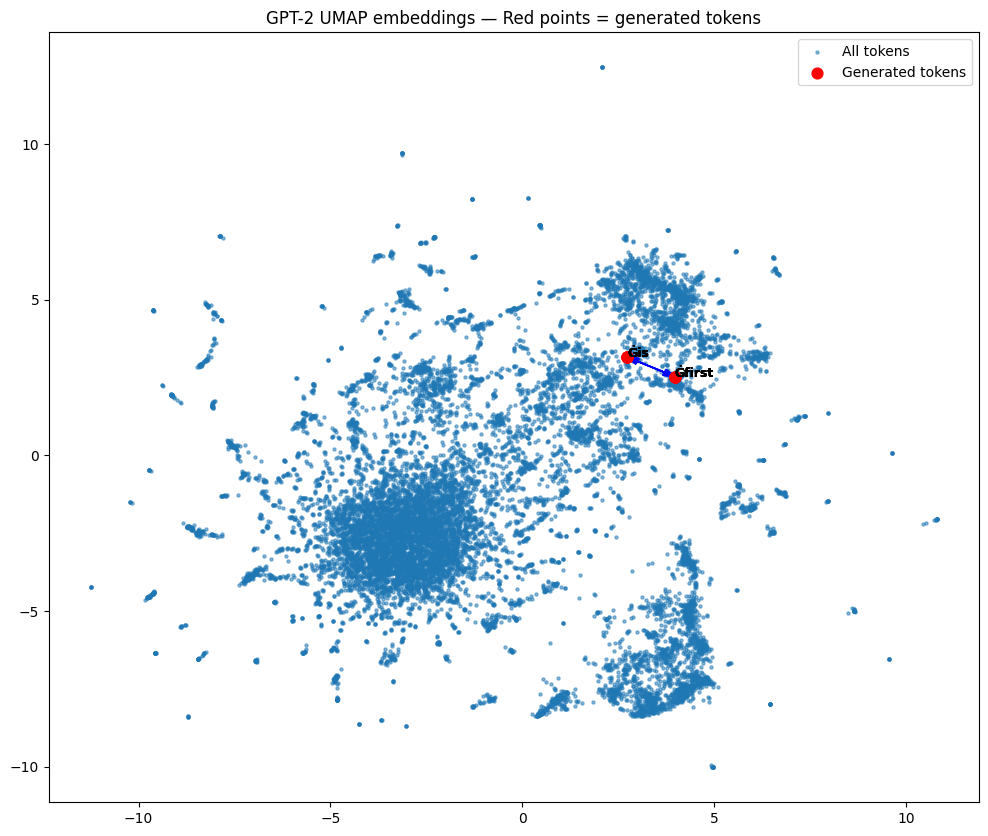

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.scatter(umap_result[:, 0], umap_result[:, 1], s=5, alpha=0.5, label="All tokens")

chosen_coords = []
chosen_labels = []  # store the token text for each chosen token

for tid in generated_token_ids:
    if tid in token_id_to_pos:
        idx_in_subset = token_id_to_pos[tid]
        chosen_coords.append(umap_result[idx_in_subset])

        token_str = tokenizer.convert_ids_to_tokens([tid])[0]
        chosen_labels.append(token_str)

chosen_coords = np.array(chosen_coords)  # shape [num_chosen, 2]


path_nodes = []
for tid in generated_token_ids:
    if tid in token_id_to_pos:
        path_nodes.append(token_id_to_pos[tid])


# draw arrows
for i in range(len(chosen_coords)-1):
    x1, y1 = chosen_coords[i]
    x2, y2 = chosen_coords[i+1]
    plt.arrow(
        x1, y1, 
        x2 - x1, y2 - y1, 
        length_includes_head=True, 
        head_width=0.2, 
        color="blue", 
        alpha=0.6
    )

# draw red dots
plt.scatter(chosen_coords[:, 0], chosen_coords[:, 1], s=60, c="red", label="Generated tokens")
for (x, y), label in zip(chosen_coords, chosen_labels):
    plt.text(x, y, label, fontsize=9, fontweight="bold")

plt.title("GPT-2 UMAP embeddings — Red points = generated tokens")
plt.legend()
plt.show()


KeyError: 0

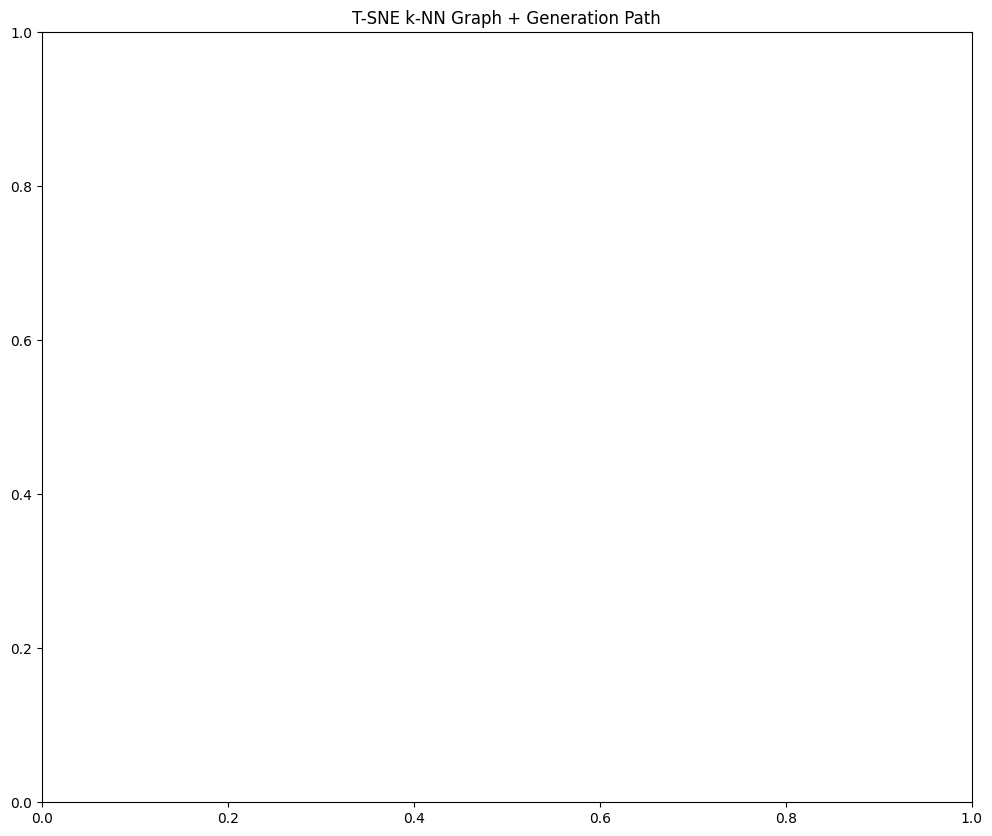

In [105]:
import matplotlib.pyplot as plt

pos = nx.get_node_attributes(G, "pos")

plt.figure(figsize=(12, 10))
plt.title("T-SNE k-NN Graph + Generation Path")

nx.draw_networkx_edges(G, pos, alpha=0.03, edge_color="gray")
nx.draw_networkx_nodes(G, pos, node_size=20, node_color="skyblue", alpha=0.5)

nx.draw_networkx_nodes(
    G, 
    pos,
    nodelist=path_nodes,
    node_color="red",
    node_size=80
)

path_edges = []
for i in range(len(path_nodes)-1):
    n1 = path_nodes[i]
    n2 = path_nodes[i+1]
    path_edges.append((n1, n2))

nx.draw_networkx_edges(
    G, 
    pos,
    edgelist=path_edges,
    edge_color="red",
    width=2,
    alpha=0.7
)

labels_dict = {}
for node_idx in path_nodes:
    gpt2_id = indices[node_idx]
    token_str = tokenizer.convert_ids_to_tokens([gpt2_id])[0]
    labels_dict[node_idx] = token_str

nx.draw_networkx_labels(G, pos, labels=labels_dict, font_size=9, font_color="black")

plt.axis("off")
plt.show()


In [85]:
for node in G.nodes():
    if "pos" in G.nodes[node]:
        x, y = G.nodes[node]["pos"]
        G.nodes[node]["pos_x"] = x
        G.nodes[node]["pos_y"] = y
        del G.nodes[node]["pos"]

nx.write_gexf(G, "random.gexf")
